In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import git
import os
import sys
root = git.Repo(os.getcwd(), search_parent_directories=True).git.rev_parse("--show-toplevel")
sys.path.append(os.path.join(root, 'data_processing'))
from make_features import load_data


In [2]:
incidents = pd.read_csv(os.path.join(root, 'data_processing/other_datasets/incidents.csv.gz'), index_col = 'incident_id')
acceleration = pd.read_csv(os.path.join(root, 'data_processing/other_datasets/acceleration.csv.gz'), index_col = ['incident_id', 'milliseconds'])

In [3]:
from make_features import make_undirected

In [4]:
features = make_undirected(acceleration)

In [5]:
from sklearn.preprocessing import StandardScaler
f = StandardScaler().fit_transform(features)
w = np.linalg.eigvals(np.cov(f.T))

In [6]:
components = (w > 1).sum()
components

10

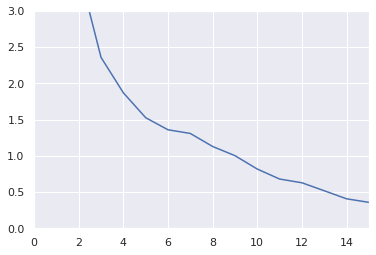

In [7]:
fig, ax = plt.subplots()
ax.plot(np.sort(w)[::-1])
ax.set_xlim(xmin = 0, xmax=components*1.5)
ax.set_ylim(ymin = 0, ymax=3)
plt.show()

In [8]:
from sklearn.decomposition import FactorAnalysis

In [9]:
fact = FactorAnalysis(n_components = components, rotation='varimax').fit(f)

In [10]:
scale = np.diag(fact.components_.T[abs(fact.components_).argmax(axis=1)])
loadings = pd.DataFrame((fact.components_.T / scale).T, columns = features.columns)

In [11]:
# this style from https://stackoverflow.com/questions/46715736/rotating-the-column-name-for-a-panda-dataframe
vertical_labels = [
    {'selector':"th", 'props':[('width', '40px')]},
    {'selector':"th.col_heading",
     'props':[("writing-mode", "vertical-rl"),
             ('transform', 'rotateZ(180deg)'), 
             ('height', '290px'),
             ('vertical-align', 'top')
            ]
    }
]
# red vs blue should be more colorblind friendly than the more usual red vs green.
styled = loadings.style.background_gradient(axis='columns', cmap = 'RdYlBu', vmin=-1, vmax=1).format(precision=2).set_table_styles(vertical_labels)
display(styled)

,beginning maximum,beginning minimum,beginning range,beginning mean,beginning standard deviation,beginning variance,beginning skew,beginning kurtosis,beginning total variation,beginning angular path length,beginning biggest angle difference,beginning low frequency power,beginning medium frequency power,beginning high frequency power,middle maximum,middle minimum,middle range,middle mean,middle standard deviation,middle variance,middle skew,middle kurtosis,middle total variation,middle angular path length,middle biggest angle difference,middle low frequency power,middle medium frequency power,middle high frequency power,end maximum,end minimum,end range,end mean,end standard deviation,end variance,end skew,end kurtosis,end total variation,end angular path length,end biggest angle difference,end low frequency power,end medium frequency power,end high frequency power
0,0.95,-0.71,0.92,0.83,0.95,1.00,0.16,-0.28,0.96,0.29,0.30,0.17,0.13,0.99,0.05,-0.33,0.07,0.55,0.33,-0.02,-0.30,-0.32,0.73,-0.33,-0.33,-0.06,-0.06,-0.04,0.67,-0.55,0.68,0.69,0.79,0.87,0.03,-0.23,0.83,-0.26,-0.26,0.06,0.00,0.87
1,-0.22,1.00,-0.43,0.22,-0.35,0.10,-0.03,0.30,-0.25,-0.04,-0.01,0.03,-0.24,0.10,0.03,0.34,0.01,0.33,0.02,-0.01,0.15,-0.03,-0.05,0.18,0.18,-0.01,-0.01,-0.01,0.08,0.33,-0.01,0.35,0.01,0.22,-0.04,0.02,0.04,-0.01,-0.01,0.04,-0.02,0.22
2,-0.19,0.29,-0.22,-0.08,-0.19,-0.09,-0.10,0.00,-0.17,0.12,0.07,-0.02,-0.10,-0.08,0.10,-0.07,0.10,0.03,0.07,-0.04,0.37,0.28,-0.02,0.78,0.77,-0.02,-0.03,-0.04,-0.21,0.33,-0.24,-0.13,-0.25,-0.11,-0.02,0.26,-0.22,1.00,1.00,-0.02,-0.11,-0.10
3,0.02,0.00,0.01,0.02,0.02,0.03,0.00,-0.03,0.02,0.09,0.09,0.01,0.01,0.03,0.97,-0.02,0.97,0.39,0.91,1.00,0.13,0.15,0.54,0.03,0.03,1.00,1.00,1.00,0.02,-0.00,0.01,0.02,0.01,0.03,0.01,0.01,0.01,0.02,0.02,0.01,-0.01,0.02
4,-0.06,0.04,-0.05,0.04,-0.01,-0.01,-0.03,-0.04,0.02,-0.00,0.02,-0.05,-0.21,-0.02,-0.01,-0.01,-0.01,0.25,0.08,-0.00,-0.21,-0.17,0.21,-0.22,-0.22,-0.01,-0.02,-0.01,1.00,-0.73,0.99,0.54,0.75,0.57,0.48,0.13,0.59,-0.10,-0.10,0.53,0.56,0.47
5,0.13,-0.11,0.13,0.20,0.14,0.11,0.03,-0.06,0.12,1.00,1.00,0.03,-0.02,0.10,0.04,0.02,0.04,0.16,0.07,0.02,0.00,0.01,0.08,0.14,0.14,0.02,0.02,0.02,0.01,0.04,-0.00,0.13,0.04,0.05,-0.07,-0.08,0.04,0.03,0.03,-0.02,-0.05,0.05
6,-0.07,0.19,-0.10,-0.10,-0.13,-0.05,0.09,0.04,-0.10,0.03,-0.01,-0.01,0.01,-0.06,0.25,0.06,0.24,-0.09,0.10,-0.06,0.96,1.00,0.03,0.26,0.26,-0.05,-0.05,-0.06,-0.17,0.36,-0.22,-0.16,-0.22,-0.08,0.02,0.03,-0.18,0.15,0.15,-0.02,-0.05,-0.06
7,0.67,-0.02,0.53,0.56,0.12,-0.21,0.97,0.31,-0.03,0.04,0.00,0.63,1.00,-0.35,0.18,0.10,0.17,0.97,0.23,-0.12,0.07,-0.08,0.32,-0.12,-0.12,-0.08,-0.10,-0.13,0.09,0.27,0.01,0.38,-0.12,-0.22,0.17,0.09,-0.16,0.02,0.02,0.36,0.11,-0.29
8,0.11,0.26,0.02,0.14,-0.09,-0.05,0.27,0.34,-0.08,-0.01,0.01,0.14,0.08,-0.07,-0.17,1.00,-0.23,-0.31,-0.39,0.17,-0.01,0.03,-0.47,-0.10,-0.10,0.12,0.14,0.19,0.04,0.20,-0.01,0.06,-0.07,-0.05,0.18,0.08,-0.06,0.02,0.02,0.02,0.09,-0.04
9,0.15,-0.01,0.12,0.12,0.07,0.11,0.04,-0.03,-0.00,-0.02,-0.03,0.16,0.33,0.11,0.02,0.15,0.01,0.05,-0.03,-0.00,0.03,-0.01,-0.11,0.01,0.01,0.01,0.01,-0.01,0.28,0.26,0.17,-0.37,-0.30,-0.28,0.82,1.00,-0.50,0.04,0.04,0.34,0.32,-0.42


In [12]:
loadings.idxmax(axis='columns')

0                  beginning variance
1                   beginning minimum
2        end biggest angle difference
3                     middle variance
4                         end maximum
5       beginning angular path length
6                     middle kurtosis
7    beginning medium frequency power
8                      middle minimum
9                        end kurtosis
dtype: object

In [13]:
chosen_features = features.loc[:, loadings.idxmax(axis='columns')]

In [14]:
chosen_features['motion'] = incidents['motion']

In [15]:
""" this cell takes a long time to run.
g = sns.PairGrid(chosen_features, hue='motion')
g.map_lower(sns.scatterplot, marker='.', hue_order=['other','trip','slip', 'fall'])
g.map_upper(sns.kdeplot, hue_order=['other','trip','slip', 'fall'])
g.map_diag(sns.kdeplot, lw=3, legend=False, hue_order=['other','trip','slip', 'fall'])
plt.savefig('pair_plot_othersets.png')
plt.show()
"""

" this cell takes a long time to run.\ng = sns.PairGrid(chosen_features, hue='motion')\ng.map_lower(sns.scatterplot, marker='.', hue_order=['other','trip','slip', 'fall'])\ng.map_upper(sns.kdeplot, hue_order=['other','trip','slip', 'fall'])\ng.map_diag(sns.kdeplot, lw=3, legend=False, hue_order=['other','trip','slip', 'fall'])\nplt.savefig('pair_plot_othersets.png')\nplt.show()\n"

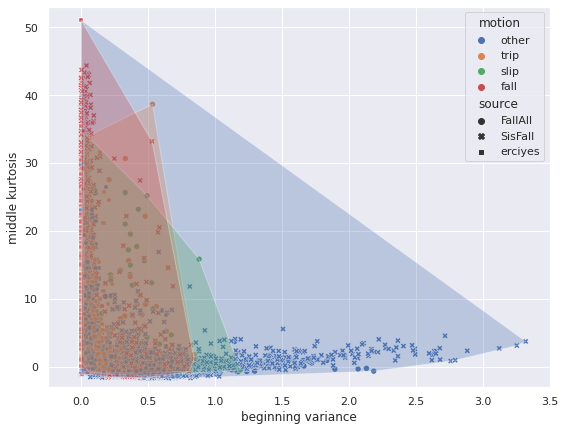

In [16]:
data = features.copy()
data['motion'] = incidents['motion']
data['source'] = data.index.str[:7]

from scipy.spatial import ConvexHull


def v_k_plot(data, source=False, hull=True):
    plt.figure(figsize=(9,7))
    plt.xlim(-0.25, 3.5)
    plt.ylim(-3, 53)
    
    if hull:
        columns = data[['beginning variance', 'middle kurtosis']]
        plt.gca().set_prop_cycle(None)
        for motion in ['other','trip','slip', 'fall']:
            subset = columns[data['motion'] == motion]
            if len(subset) >= 3:
                points = subset.values
                hull = ConvexHull(points)
                x = points[hull.vertices][:, 0]
                y = points[hull.vertices][:, 1]
            else:
                # plot something to advance the color counter
                x = np.zeros(0)
                y = np.zeros(0)
            plt.fill(x, y, alpha=0.3)
    
    sns.scatterplot(data=data, x = 'beginning variance', y='middle kurtosis', hue='motion', hue_order=['other','trip','slip', 'fall'], **({'style':'source'} if source else {}))
            
    
v_k_plot(data, source=True)
plt.savefig('variance_vs_kurtosis_other_datasets.png')
plt.show()

In [17]:
pd.crosstab(data['motion'], data['source'])

source,FallAll,SisFall,erciyes
motion,,,
fall,112,1661,1846
other,741,2673,1010
slip,231,0,0
trip,85,111,407


In [18]:
df = data[data['middle kurtosis']>10][['motion', 'source']]

pd.crosstab(df['motion'], df['source'])

source,FallAll,SisFall,erciyes
motion,,,
fall,61,1158,389
other,131,147,85
slip,84,0,0
trip,21,8,18


In [19]:
df = data[data['beginning variance']>1][['motion', 'source']]

pd.crosstab(df['motion'], df['source'])

source,FallAll,SisFall
motion,,
other,62,232
slip,1,0


In [20]:
i, a = load_data()

In [21]:
f = make_undirected(a)

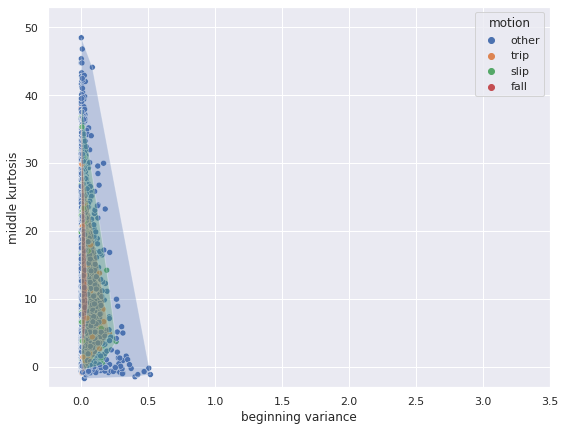

In [22]:
makusafe = f.copy()
makusafe['motion'] = i['motion']

v_k_plot(data=makusafe)
plt.savefig('variance_vs_kurtosis_makusafe.png')
plt.show()

In [23]:
high_acceleration_incidents = (acceleration.xs(0, level=1).abs()>2).any(axis=1)

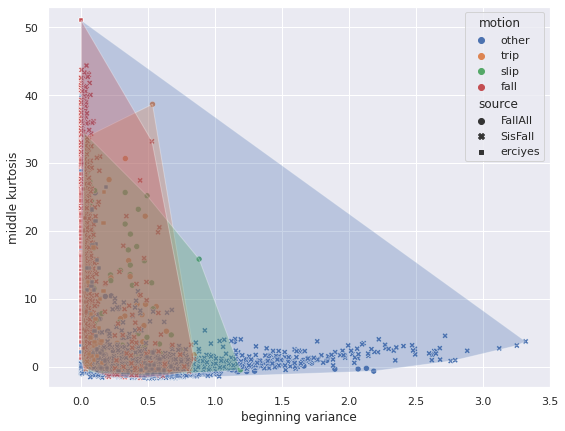

In [24]:
high_acc = features[high_acceleration_incidents].copy()
high_acc['motion'] = incidents[high_acceleration_incidents]['motion']
high_acc['source'] = high_acc.index.str[:7]

v_k_plot(data=high_acc, source=True)

FallAll


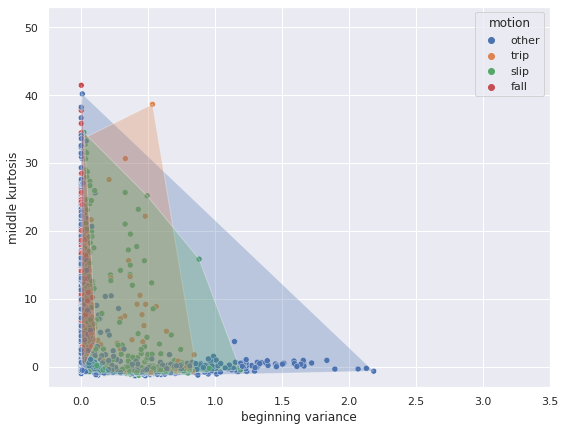

SisFall


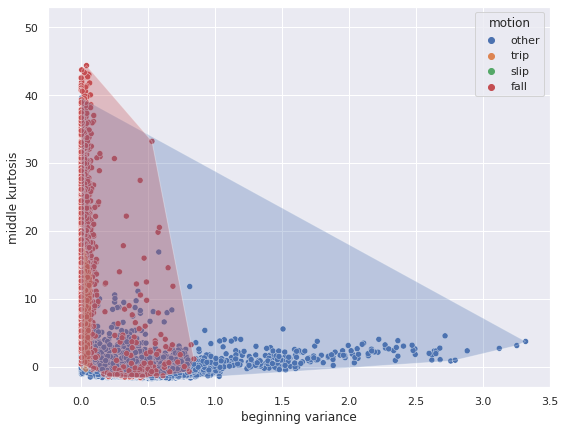

erciyes


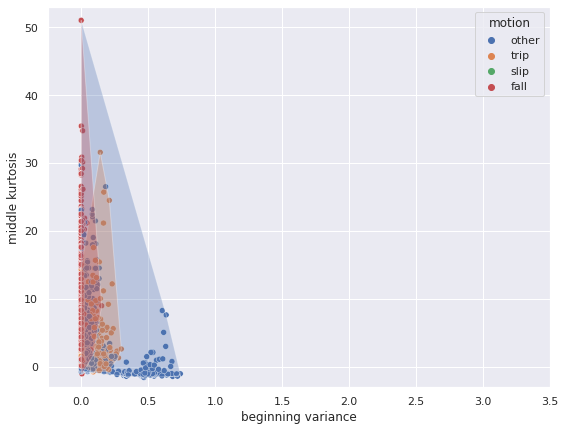

In [25]:
for source in ['FallAll', 'SisFall', 'erciyes']:
    print(source)
    v_k_plot(data=data[data['source'] == source])
    plt.savefig(f'variance_vs_kurtosis_{source}.png')
    plt.show()